# Vector Autoregression

Notebook created on 2nd May 2023

***

#### Abstract:

Vector Autoregression expands 1D AR model into multi-variables. It is widely used in finance and economics. In reduced form, contemporary relationship is embedded in the error term; in structural form SVAR, the structural shocks are uncorrelated, and contemporary effects are explicitly given on the left side.

Below it uses VAR to investigate lead-lag relationships between prices and trading volume, including Granger causality and impulse responses.

Notebook Reference: [Statsmodel Documentation here](https://www.statsmodels.org/stable/vector_ar.html?highlight=var#module-statsmodels.tsa.vector_ar.var_model).

***

In [1]:
import numpy as np
import pandas as pd
import scipy
from datetime import datetime, timedelta
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt
import pandas_datareader as pdr
import yfinance as yf

import warnings 
warnings.filterwarnings("ignore")

In [2]:
start_date = '2020-01-01'
end_date = '2023-05-02'
ticker = '^GSPC'

spx = yf.download(ticker, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


In [3]:
price_chg = np.log(spx['Close']) - np.log(spx['Close'].shift(1))  # shift 1 shifts forward one day; today has yesterday's price
volume_chg = np.log(spx['Volume']) - np.log(spx['Volume'].shift(1))  # shift 1 shifts forward one day; today has yesterday's price
price_chg = price_chg * 100.0
volume_chg = volume_chg * 100.0
price_chg.dropna(inplace=True)
volume_chg.dropna(inplace=True)
print(price_chg.shape, volume_chg.shape)

(837,) (837,)


In [4]:
# Contemporaneous correlations between return and trading volume is less significant than absolute return and trading volume.
data = pd.merge(price_chg, volume_chg, left_index=True, right_index=True)
data.rename(columns={'Close': 'Price'}, inplace=True)
print(data.corr())
data = pd.merge(np.abs(price_chg), volume_chg, left_index=True, right_index=True)
data.rename(columns={'Close': 'Price'}, inplace=True)
print(data.corr())

           Price    Volume
Price   1.000000 -0.119508
Volume -0.119508  1.000000
           Price    Volume
Price   1.000000  0.093239
Volume  0.093239  1.000000


In [5]:
# train test split
data_training = data.iloc[:-22]
data_test = data.iloc[-22:]
model = VAR(data_training)

In [6]:
ms = model.select_order(45)      # 45 business days, roughly two months
ms.summary()

,AIC,BIC,FPE,HQIC
0,5.973,5.985,392.9,5.978
1,5.655,5.691,285.7,5.669
2,5.454,5.514,233.6,5.477
3,5.413,5.497,224.3,5.445
4,5.389,5.497*,218.9,5.431
5,5.368,5.501,214.5,5.419
6,5.349,5.506,210.3,5.409*
7,5.341,5.522,208.8,5.411
8,5.339,5.544,208.3,5.418
9,5.335,5.564,207.4,5.423


In [7]:
results  = model.fit(maxlags=45, ic='aic')

In [8]:
# best lag order is 32, around 6 weeks
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 02, May, 2023
Time:                     13:50:48
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    5.68492
Nobs:                     802.000    HQIC:                   5.49055
Log likelihood:          -4375.08    FPE:                    214.730
AIC:                      5.36933    Det(Omega_mle):         200.970
--------------------------------------------------------------------
Results for equation Price
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const              0.212618         0.056868            3.739           0.000
L1.Price           0.083428         0.036438            2.290           0.022
L1.Volume          0.003784         0.002302            1.644           

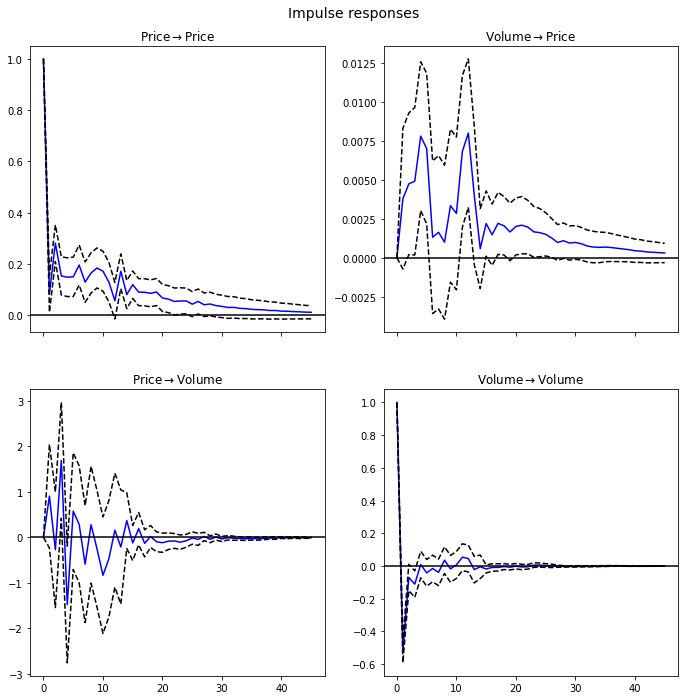

In [9]:
# volume --> price has positive shocks which dies out over time; which matches our intuition.
# volume --> volume has negative shocks; suggests mean reversion
irf = results.irf(45)
irf.plot(orth=False);
# irf.plot(impulse='Volume');

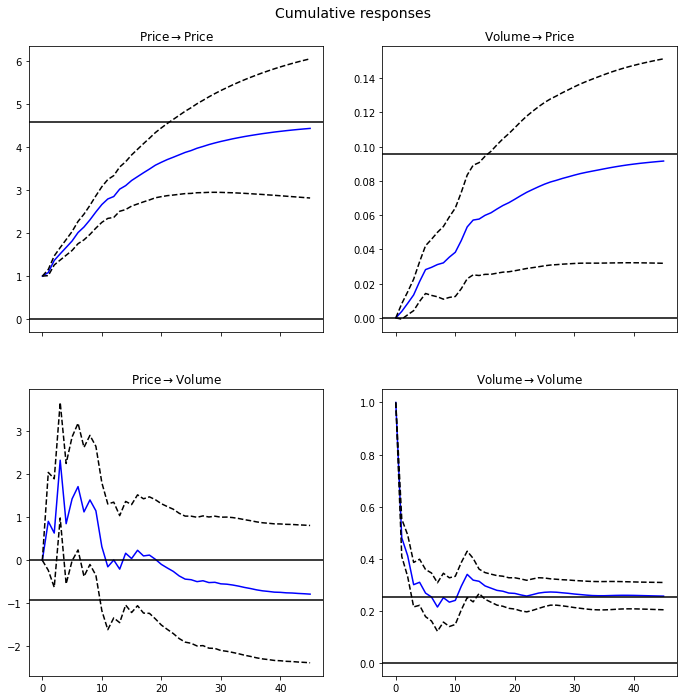

In [10]:
irf.plot_cum_effects(orth=False);

FEVD for Price
        Price    Volume
0    1.000000  0.000000
1    0.996558  0.003442
2    0.991913  0.008087
3    0.987025  0.012975
4    0.975043  0.024957
5    0.966183  0.033817
6    0.966933  0.033067
7    0.966911  0.033089
8    0.967447  0.032553
9    0.966430  0.033570

FEVD for Volume
        Price    Volume
0    0.040217  0.959783
1    0.033660  0.966340
2    0.034272  0.965728
3    0.039273  0.960727
4    0.045392  0.954608
5    0.045907  0.954093
6    0.046062  0.953938
7    0.047475  0.952525
8    0.047875  0.952125
9    0.048137  0.951863




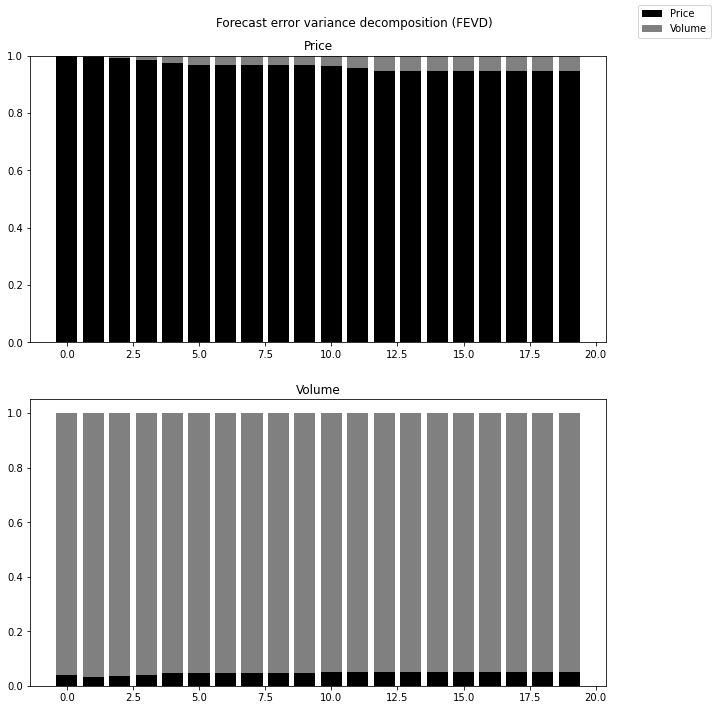

In [11]:
# autocorrelation with itself dominates
fevd = results.fevd(10)
fevd.summary()
results.fevd(20).plot();

In [12]:
gc = results.test_causality('Price', ['Price', 'Volume'], kind='f')
gc.summary()

Test statistic,Critical value,p-value,df
17.90,1.503,0.000,"(26, 1550)"


In [13]:
# H_0 rejected; Volume has incremental explanation power.
gc = results.test_causality('Price', ['Volume'], kind='f')
gc.summary()

Test statistic,Critical value,p-value,df
2.439,1.726,0.003,"(13, 1550)"


In [14]:
# Normality is rejected; the model needs improvements; probably GARCH.
nt = results.test_normality()
nt.summary()

Test statistic,Critical value,p-value,df
3924.,9.488,0.000,4


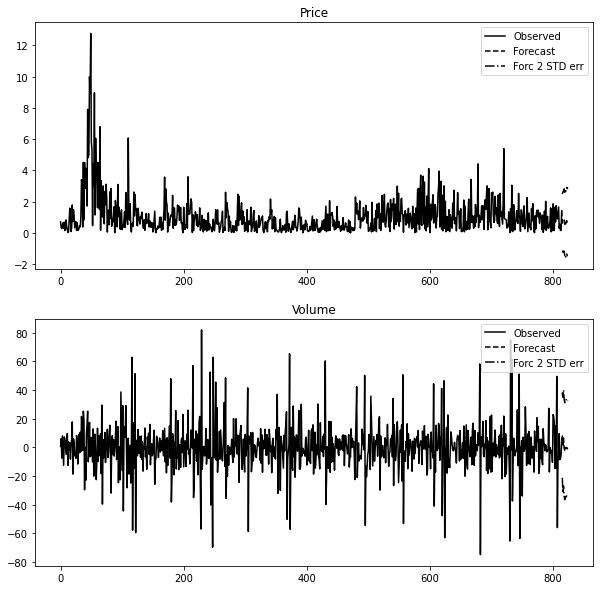

In [15]:
# forecast
results.plot_forecast(10);

In [16]:
lag_order = results.k_ar
# results.forecast(data.values[-lag_order:], 5)
m, l, u = results.forecast_interval(data.values[-lag_order:], data_test.shape[0])

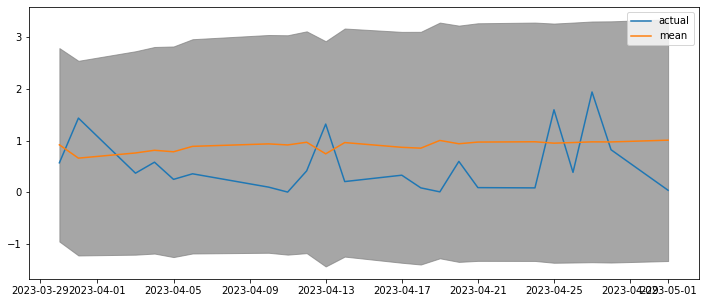

In [17]:
# Return forecast

plt.figure(figsize=(12, 5))
plt.plot(data_test['Price'], label='actual')
plt.plot(pd.DataFrame(m[:, 0], index=data_test.index), label='mean')
plt.fill_between(data_test.index, l[:, 0], u[:, 0], color='gray', alpha=0.7)
plt.legend()
plt.show()

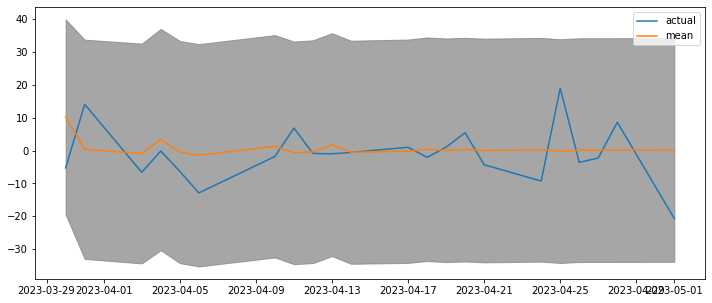

In [18]:
plt.figure(figsize=(12, 5))
plt.plot(data_test['Volume'], label='actual')
plt.plot(pd.DataFrame(m[:, 1], index=data_test.index), label='mean')
plt.fill_between(data_test.index, l[:, 1], u[:, 1], color='gray', alpha=0.7)
plt.legend()
plt.show()

# Disclaimer

This notebook is entirely informative. None of the content presented in this notebook constitutes a recommendation that any particular security, portfolio of securities, transaction or investment strategy is suitable for any specific person. Futures, stocks and options trading involves substantial risk of loss and is not suitable for every investor. The valuation of futures, stocks and options may fluctuate, and, as a result, clients may lose more than their original investment.

Thanks for reading!

Best,
Chrisler